# Linear Regression: a Machine Learning Perspective

At it's core, machine learning is simply the process of extracting insight from data. Instead of sitting on an armchair and philosophizing about the world, we go out and get data, then try to have the data to tell us how the world works. Ultimately this comes down to fitting models to data. Often this ends with fitting complex neural networks with millions of parameters to massive quantities of data. But that is so complicated it can be hard to really see what is going on. In this notebook we will introduce some classic machine learning concepts, but in the context of Linear Regression which is much simpler to understand.

In [2]:
# If using a local jupyter notebook you might need this line:
# !pip install numpy scipy matplotlib scikit-learn torch

In [3]:
import numpy as np
from copy import copy
%matplotlib inline
#%matplotlib notebook
import shutil
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
plt.xkcd()
plt.rcParams['font.family'] = 'Humor Sans'
from scipy.optimize import minimize
import torch
from sklearn.model_selection import KFold

colours = ["k","#FCE233", "#FC8565"]
def cov_to_ellipse(cov):
    eigvals, eigvecs = np.linalg.eig(cov)
    axes = np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    return axes, angle

# Check this out for all the details on Linear Regression: https://arxiv.org/abs/1008.4686

![xkcd_extrapolating.png](https://imgs.xkcd.com/comics/extrapolating.png)

## The Math of Linear Regression

Let us say we find ourselves in a particular situation. We have designed our experiment in such a way that there are some set of variables $\vec{x}$ which may be set and then we will measure some output result $y$. The measurements are subject to uncertainty which will perturb the measurement by some value $\epsilon$ which is a random varaible with mean zero and standard deviation $\sigma$. We suspect that there is a linear relationship in this experiment and so for some set of parameters $\vec{\theta}$, for a given experiment $i$ we should be able to write:

$$y_i = \vec{\theta}\cdot\vec{x}_i + \epsilon_i, ~\epsilon_i\sim\mathcal{N}(0,\sigma_c^2)$$

Now let's think about a more general case, $y_i$ instead of being a single scalar output, could be a whole vector $\vec{y}$. To map from the $\vec{x}$ to $\vec{y}$ we need a matrix, so now our parameters are a $\Theta$ matrix. Each element of $\vec{y}$ will get different noise, so this means $\epsilon_i$ will become a vector too. This very general form looks like:

$$\vec{y} = \Theta\vec{x} + \vec{\epsilon}, ~\vec{\epsilon}\sim\mathcal{N}(0,C)$$

where our noise is now drawn by a multivariate gaussian with covariance matrix $C$. Note that our data will consist of $(\vec{x}_i, \vec{y}_i)$ pairs, the things we don't know are $\Theta$ and the individual noise realizations $\vec{\epsilon}_i$. So we run the experiment many times. For $N$ experiments our inputs will become $\vec{x} \to X$ a matrix, and the measurements will become $\vec{y} \to Y$ another matrix. The perturbations will also become a matrix, adding a new unknowns every time we run an experiment, however the $\vec{\epsilon}_i$ will be drawn from known Gaussian distributions (each experiment must have the same $C$ for now...) and we will use that to our advantage.

The parameters $\Theta$ can be thought of as a generative model. Meaning that if the $\Theta$ were known, then for any input variables $\vec{x}$ we could produce a good prediction for the measurement $\vec{y}$. To be fully general we could write our generative model as $f(\vec{x}) = \Theta\vec{x}$ just a function which takes inputs and produces an output $\vec{y}$, but for now we are focusing specifically on the linear case.

In this situation we have plenty of experiemnts ($\vec{x}$, $\vec{y}$) and we would like to find the model parameters $\Theta$ that best fit the data. But what does that actually mean? In truth, there is uncertainty on our measurements so there will be uncertainty on our fitted parameters. What we are looking for is a probability distribution which describes the information that the measurements have given us about the model. This is very hard, so lets flip the question on its head. If we knew the model parameters $\Theta$ what is the pobability we would have gotten a given set of measurements? This can actually be answered very easily when we have a generative model and the uncertainty is Gaussian (some big assumptions). For a single output $y_i$ model, we can write the likelihood for a given observation as:

$$\mathcal{L}(y_i) = \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{\left(y_i - \vec{\theta}\cdot\vec{x}_i\right)^2}{2\sigma_i^2}\right)$$

$$\mathcal{L}(\vec{y}) = \Pi_i \mathcal{L}(y_i)$$

The likelihood for multiple observations is just the product of these likelihoods under the assumption that they are all independent. Also, it is more straightforward to represent the negative log likelihood, which is basically the $\chi^2$:

$$\frac{1}{2}\chi^2 = -\log(\mathcal{L}(\vec{y})) = \sum_i \frac{\left(y_i - \vec{\theta}\cdot\vec{x}_i\right)^2}{2\sigma_i^2} + \frac{1}{2}\log(2\pi\sigma_i^2)$$

More generally, we can write this as:

$$\chi^2 = (\vec{y} - X\vec{\theta})^TC^{-1}(\vec{y} - X\vec{\theta}) + \log(||2\pi C||)$$

The value $\frac{1}{2}\log(||2\pi C||)$ is a scalar constant which is the determinant of the covariance matrix, which won't be relevant for fitting the parameters (for now) since it is constant.

If we find the minimum $\chi^2$ then we will have found the maximum likelihood point, the parameters which best satisfy the data. A bit of calculus and rearranging and you will arrive at this expression for the parameters:

$$\vec{\theta} = [X^TC^{-1}X]^{-1}X^TC^{-1}\vec{y}$$

That is just the maximum likelihood though, completely useless unless we also know the uncertainty on our parameters. As it turns out, that is just as striaghtforward. The matrix $[X^TC^{-1}X]^{-1}$ is the covariance matrix of uncertainties for the parameters $\vec{\theta}$.

which means it is possible to simply write out the solution to a linear regression problem. No iterative solvers needed, we can just do algebra to get the answer, neat! Too bad it won't stay so easy.

If $y$ is a vector then to solve for the parameters, we use the same formula, except now Y also becomes a matrix (a vector for each observation combined into a matrix).

$$\Theta = [X^TC^{-1}X]^{-1}X^TC^{-1}Y$$

In [4]:
def Theta(X, Y, C):
  Cinv = np.linalg.inv(C)
  F = np.linalg.inv(X.T @ Cinv @ X)
  T = F @ X.T @ Cinv @ Y
  return T, F

def Theta_torch(X, Y, C):
  Cinv = torch.linalg.inv(C)
  F = torch.linalg.inv(X.T @ Cinv @ X)
  T = F @ X.T @ Cinv @ Y
  return T, F

![xkcd_slope_hypothesis_testing.png](https://imgs.xkcd.com/comics/slope_hypothesis_testing.png)



### Reframe as machine learning problem

The math above is quite abstract and applies in many situations. Lets rewrite it in machine learning terminology.

First, the vector $\vec{x}$ is our input, this can be called the "features" of the data. Another way to refer to it is as the "embedding" of the data. Note that we don't have to use the data we recieve directly as the embedding, we can make modifications. For example, we might want to rescale all our data so that the average $\vec{x}$ has a mean of 0 and in each axis the variance is 1. This is a common step called "preprocessing" used in machine learning. Another option is to add extra dimensions. For example we could include the squared terms so $\vec{x} = (x_0, x_1, ...)$ becomes $\vec{x}' = (x_0, x_0^2, x_1, x_1^2, ...)$ which actually allows us to fit nonlinear functions (see later section). Finally, $\vec{x}$ may not come to us as a vector, perhaps we are given images, but we can treat them all as vectors for our purposes since that just involves re-ordering the data.

Now, the vector $\vec{y}$ is our output, this is what our model is trying to predict, so it can also be called a prediction. If we apply some operation to take the output and map it into a set of integers (say 0 for negative outputs and 1 for positive outputs) then we could alternatively call $\vec{y}$ the classification. If $\vec{y}$ is supposed to represent samples from a data space (say an image) then we would say that our model is a generative model.

The $\Theta$ matrix is our "weights", these are the parameters we actually need to optimize, so this is learning part of the machine learning.

The $\chi^2$, $(\vec{y} - X\vec{\theta})^TC^{-1}(\vec{y} - X\vec{\theta})$, in machine learning language would be called the "loss". We generally try to minimize the loss as a way to optimize the weights. In fact the common "mean squared error" loss is very literally assuming a gaussian model for the data and the loss is indeed a $\chi^2$.

The whole linear regression problem is actually mathematically very close to a "perceptron" which is the basic building block of most neural networks.

## Standard Linear Regression

Now that we have our linear algebra to solve a linear regression problem, let's give it a try

true parameter value: [1]
predicted parameter value: [0.79629808]
prediction uncertainty covariance matrix [[0.00754374]]
prediction uncertainty standard deviation [0.08685468]


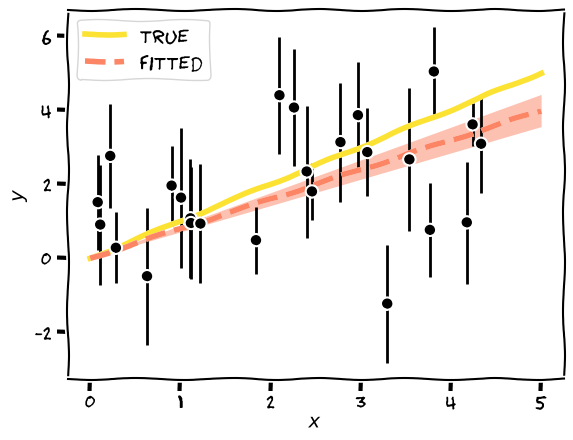

In [5]:
# Set up the observation
N = 25
true_params = np.array([1]) ### Set the true value for the slope
inputs = np.random.uniform(0,5,(1,N)).T
covariance = np.diag(np.random.uniform(0,4,N))
observations = np.dot(true_params, inputs.T) + np.random.normal(loc = 0, scale = np.sqrt(np.diag(covariance)))

# Make prediction using linear algebra
predicted_parameters, predicted_covariance = Theta(inputs, observations, covariance)

# Plot the results
print(f"true parameter value: {true_params}")
print(f"predicted parameter value: {predicted_parameters}")
print(f"prediction uncertainty covariance matrix {predicted_covariance}")
print(f"prediction uncertainty standard deviation {np.sqrt(np.diag(predicted_covariance))}")
plt.errorbar(inputs.T[0], observations, yerr = np.sqrt(np.diag(covariance)), fmt = 'o', color = colours[0])
x = np.linspace(0,5,N).reshape(1,N)
plt.plot(x[0], np.dot(true_params, x), color = colours[1], linewidth = 4, label = "true")
y_pred = np.dot(predicted_parameters, x)
y_std = np.sqrt(x[0]**2 * predicted_covariance[0][0]) # sigma_y^2 = cov_i * (dy/dtheta_i)^2
plt.fill_between(x[0], y_pred - y_std, y_pred+y_std, color = colours[2], linewidth = 0, alpha = 0.5)
plt.plot(x[0], y_pred, color = colours[2], linewidth = 4, linestyle = "--", label = "fitted")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

FIG: the x-axis is our independent variable $x$ and the y-axis is our measurement $y$. The scatter points show individual measurements and their uncertainty. The yellow line is the true underlying linear relationship used to generate the data and the dashed line is our maximum likelihood estimate.

![xkcd_linear_regression_2x.png](https://imgs.xkcd.com/comics/linear_regression.png)

### Linear Regression for a non-linear problem

Next lets fit a non-linear function, a polynomial, using the math we derrived above. How can we do this? So long as we can get the equation in the right form, all of the algebra above applies. That is, we need to make the equation look like:

$$y = \vec{\theta}\cdot\vec{x} = \theta_0x_0 + \theta_1x_1 + \theta_2x_2 + ...$$

Well if we let $x_0 = 1$ and $x_1 = x$ and $x_2 = x^2$ up to $x_n = x^n$, then we have ourselves a linear equation to solve! Note that it doesn't have to be polynomails, we could throw anything we want in there (i.e. we could make $x_3 = \log(x)$) so long as the final form looks like the above and we are only trying to solve for the $\theta_i$ values. Written as a dot product, our linear model is:

$$ y = \theta_0 + \theta_1x + \theta_2x^2 + ... + \theta_nx^n = [\theta_0, \theta_1, \theta_2, ..., \theta_n]\begin{bmatrix} 1 \\ x \\ x^2 \\ \vdots \\ x^n \end{bmatrix}$$

true parameter values: [1.         1.         0.5        0.16666667 0.04166667]
predicted parameter value: [-0.25901422  1.62622596  1.63975924 -0.02219855 -0.127462  ]
prediction uncertainty covariance matrix
[[ 0.86347024 -0.28233821 -0.54423957  0.05072802  0.05923051]
 [-0.28233821  0.7652904   0.32945739 -0.12197517 -0.04448793]
 [-0.54423957  0.32945739  0.61227375 -0.06217074 -0.07528168]
 [ 0.05072802 -0.12197517 -0.06217074  0.02255598  0.00892076]
 [ 0.05923051 -0.04448793 -0.07528168  0.00892076  0.00981634]]
prediction uncertainty standard deviation [0.92923099 0.87480878 0.78247923 0.1501865  0.09907746]


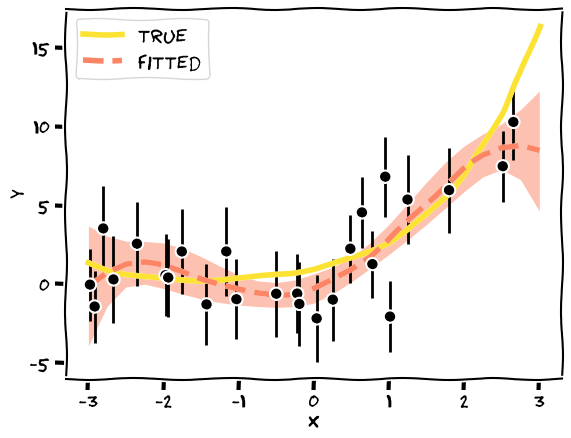

In [6]:
# Set up the observation
N = 25
true_params = np.array([1, 1, 1/2, 1/6, 1/24]) # this is just a taylor expansion of an exponential, could choose anything
inputs = np.random.uniform(-3,3,(1,N)).T # these are the x values, to make all the inputs we will need some powers
inputs = inputs * np.ones((1, 5))
for i in range(len(true_params)):
    inputs.T[i] = inputs.T[i]**i # make it a polynomial
covariance = np.diag(np.random.uniform(4,8,N))
observations = np.dot(true_params, inputs.T) + np.random.normal(loc = 0, scale = np.sqrt(np.diag(covariance)))

# Make prediction using linear algebra
predicted_parameters, predicted_covariance = Theta(inputs, observations, covariance)

# Plot the results
print(f"true parameter values: {true_params}")
print(f"predicted parameter value: {predicted_parameters}")
print(f"prediction uncertainty covariance matrix\n{predicted_covariance}")
print(f"prediction uncertainty standard deviation {np.sqrt(np.diag(predicted_covariance))}")
plt.errorbar(inputs.T[1], observations, yerr = np.sqrt(np.diag(covariance)), fmt = 'o', color = colours[0])
x = np.linspace(-3,3,N).reshape(1,N) * np.ones((5,1))
for i in range(len(true_params)):
    x[i] = x[i]**i
plt.plot(x[1], np.dot(true_params, x), color = colours[1], linewidth = 4, label = "true")
y_var = np.zeros(N)
y_pred = np.dot(predicted_parameters, x)
for i in range(len(true_params)):
  for j in range(len(true_params)):
    y_var += predicted_covariance[i,j] * np.abs(x[i] * x[j]) # sigma_y^2 = sum_i sum_j cov_ij * abs(dy/dtheta_i * dy/dtheta_j)
y_std = np.sqrt(y_var)
plt.fill_between(x[1], y_pred - y_std, y_pred + y_std, color = colours[2], linewidth = 0, alpha = 0.5)
plt.plot(x[1], y_pred, color = colours[2], linewidth = 4, linestyle = "--", label = "fitted")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

FIG: same as the above figure except now with a non-linear fit using linear regression.

![xkcd_fitting_dirk.001.png](https://imgs.xkcd.com/comics/curve_fitting.png)

## Optimization of $\chi^2$ without analytic solution (Grid)

It's nice that for linear Regression we can analytically solve for the optimal parameters. But this is almost never possible in real world problems, so we need a way to solve these problems in general. Our problem is well defined, we have some $\chi^2$ which is a function of our parameters and data, we would like to find the values for the parameters which minimize the $\chi^2$. Let's start with the simplest possible method, we will grid our space and just find the optimal parameters.

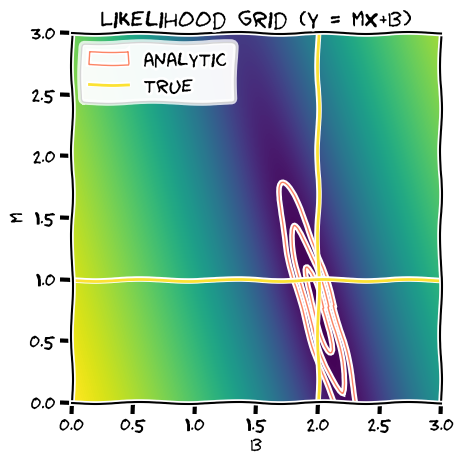

true parameter values: [1 2]
grid parameter values: (0.7575757575757576, 2.0)
analytic parameter value: [0.75506239 2.00481252]
analytic uncertainty covariance matrix
[[ 0.11782436 -0.03338761]
 [-0.03338761  0.01152262]]
analytic uncertainty standard deviation [0.34325554 0.10734345]


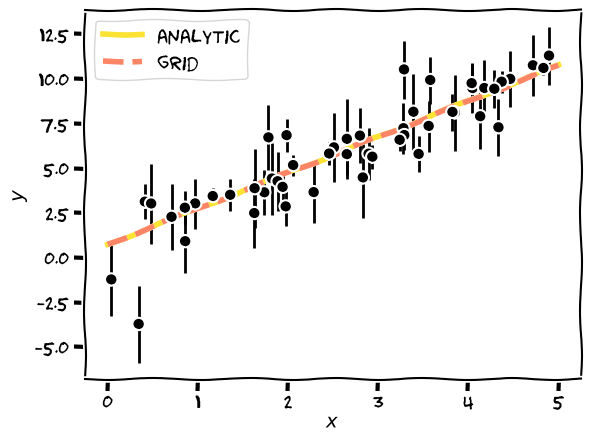

In [7]:
# Set up the observation
N = 50
true_params = np.array([1, 2]) ### Set the true value for the intercept and slope
inputs = np.concatenate((np.ones((50,1)), np.random.uniform(0,5,(1,N)).T), axis = 1)
covariance = np.diag(np.random.uniform(0,5,N))
observations = np.dot(true_params, inputs.T) + np.random.normal(loc = 0, scale = np.sqrt(np.diag(covariance)))

# Make prediction using linear algebra
analytic_parameters, analytic_covariance = Theta(inputs, observations, covariance)

# Make prediction using gridding
def loss(theta):
    # sum_i (y_i - theta*x_i) / sigma_i^2
    return np.sum((observations - np.dot(theta, inputs.T))**2 / np.diag(covariance))
Ngrid = 100
param_space = np.linspace(0,3,Ngrid)
loss_grid = np.zeros((Ngrid, Ngrid))
for x0i, x0 in enumerate(param_space):
    for x1i, x1 in enumerate(param_space):
        loss_grid[x0i,x1i] = loss(np.array((x0,x1)))
grid_parameters = np.unravel_index(np.argmin(loss_grid), loss_grid.shape)
grid_parameters = (param_space[grid_parameters[0]], param_space[grid_parameters[1]])
plt.imshow(np.log10(loss_grid), origin = "lower", extent = (param_space[0], param_space[-1], param_space[0], param_space[-1]), interpolation = "bicubic", label = "grid")
lambda_, v = np.linalg.eig(analytic_covariance)
lambda_ = np.sqrt(lambda_)
angle = np.rad2deg(np.arctan2(v[0, 0], v[1, 0]))
for k in [1,2,3]:
    ellipse = Ellipse(
        xy=(analytic_parameters[1], analytic_parameters[0]),
        width=lambda_[0] * k * 2,
        height=lambda_[1] * k * 2,
        angle=angle,
        edgecolor=colours[2],
        facecolor='none',
        label = "analytic" if k == 1 else None,
    )
    plt.gca().add_artist(ellipse)
plt.axvline(true_params[1], color = colours[1], label="true")
plt.axhline(true_params[0], color = colours[1])
plt.title("Likelihood grid (y = mx+b)")
plt.legend()
plt.xlabel("b")
plt.ylabel("m")
plt.show()

# Plot the results
print(f"true parameter values: {true_params}")
print(f"grid parameter values: {grid_parameters}")
print(f"analytic parameter value: {analytic_parameters}")
print(f"analytic uncertainty covariance matrix\n{analytic_covariance}")
print(f"analytic uncertainty standard deviation {np.sqrt(np.diag(analytic_covariance))}")
plt.errorbar(inputs.T[1], observations, yerr = np.sqrt(np.diag(covariance)), fmt = 'o', color = colours[0])
x = np.concatenate((np.ones((1,50)), np.linspace(0,5,N).reshape(1,N)), axis = 0)
plt.plot(x[1], np.dot(analytic_parameters, x), color = colours[1], linewidth = 4, label = "analytic")
plt.plot(x[1], np.dot(grid_parameters, x), color = colours[2], linewidth = 4, linestyle = "--", label = "grid")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

There is a big problem with grid optimization, the curse of dimensionality. Imagine we want to a nice fine gridding of 100 points between the limits of each parameter. With the two dimensions above, that means 10,000 likeihood evaluations, a lot but manageable. Now many real world problems involve 10 or more parameters, and in machine learning there can often be millions of parameters! For just 10 parameters, the number of likelihood evaluations skyrockets to $100,000,000,000,000,000,000$ which is entirely impossible, just imagine a machine learning algorithm!

<!-- ![Betancourt.png](attachment:Betancourt.png)

![curse](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/curse-dimensionality-feature-space.png)
![curse](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/curse-dimensionality-two-dimensional-feature-space.png)
![curse](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/curse-dimentionality-three-dimensional.png)

ref: Betancourt 2017 -->

## Optimization using $\chi^2$ samples (MCMC)

Another option is to simply guess and check. Don't laugh, this is actually one of the most widely used algorithms in science, it's called a Markov-Chain Monte-Carlo. It works by randomly adjusting the parameters, then checking to see how the $\chi^2$ has changed. If it decreases we accept the random step, if it increases we will only accept the step with some probability based on how badly the value got worse. It turns out that this simple procedure (Metropolis Hastings) will eventually explore the whole parameter space, but it will mostly focus on the high likelihood regions which is what we care about.  

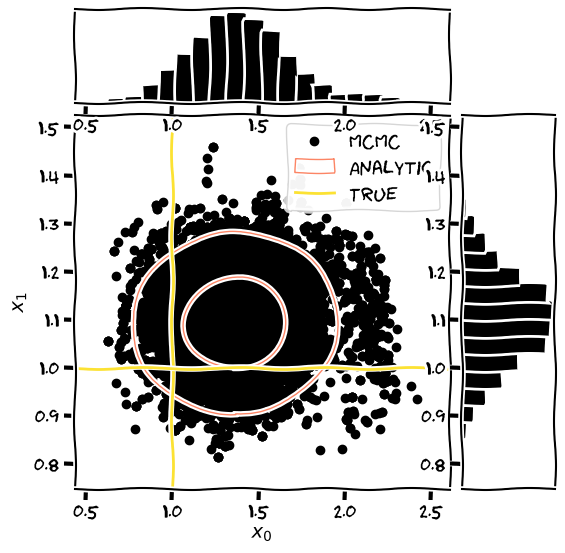

In [8]:
# Set up the observation
N = 50
true_params = np.array([1, 1, 1/2]) # this is just a taylor expansion of an exponential
inputs = np.random.uniform(-3,3,(1,N)).T # these are the x values, to make all the inputs we will need some powers
inputs = inputs * np.ones((1, 3))
for i in range(len(true_params)):
    inputs.T[i] = inputs.T[i]**i # make it a polynomial
covariance = np.diag(np.random.uniform(0,4,N))
observations = np.dot(true_params, inputs.T) + np.random.normal(loc = 0, scale = np.sqrt(np.diag(covariance)))

# Do the analytic solution for comparison
analytic_parameters, analytic_covariance = Theta(inputs, observations, covariance)

# Metropolis-Hastings MCMC
def metropolis_hastings(target_distribution, start_position, total_samples = 10000, proposal_std=0.05):
    samples = []
    current_position = start_position

    for i in range(total_samples):
        # Propose a new position
        proposed_position = np.random.normal(loc=current_position, scale=proposal_std)

        # Calculate acceptance probability
        acceptance_probability = min(1, np.exp(target_distribution(current_position)-target_distribution(proposed_position)))
        # Decide whether to accept the proposed position
        if np.random.rand() < acceptance_probability:
            current_position = proposed_position

        samples.append(current_position)

    return np.stack(samples)

# This computes the negative log likelihood for a given set of parameters theta. This is what we need to minimize to find the maximum likelihood
cov_inv = np.linalg.inv(covariance)
def nll(theta):
    A = (observations - np.dot(theta, inputs.T))
    return 0.5 * A.T @ cov_inv @ A
chain = metropolis_hastings(nll, analytic_parameters)

# Plot the results
compare_params = (0,1)
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(
    2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
    left=0.1, right=0.9, bottom=0.1, top=0.9,
    wspace=0.05, hspace=0.05
)
ax = fig.add_subplot(gs[1, 0])

ax.scatter(chain[:,compare_params[0]],chain[:,compare_params[1]], label = "MCMC", color = colours[0])
mu, ang = cov_to_ellipse(np.array([[analytic_covariance[compare_params[0],compare_params[0]],analytic_covariance[compare_params[0],compare_params[1]],],[analytic_covariance[compare_params[1],compare_params[0]],analytic_covariance[compare_params[1],compare_params[1]],]]))
for sigma in [1,2]:
    ax.add_patch(Ellipse(
        xy = (analytic_parameters[compare_params[0]],analytic_parameters[compare_params[1]]),
        width = mu[0]*2*sigma,
        height = mu[1]*2*sigma,
        angle = ang,
        fill = False,
        edgecolor = colours[2],
        label = "Analytic" if sigma == 1 else None,
    ))
ax.axvline(true_params[compare_params[0]], label = "True", color = colours[1])
ax.axhline(true_params[compare_params[1]], color = colours[1])
ax.legend()
ax.set_xlabel(f"$x_{{{compare_params[0]}}}$")
ax.set_ylabel(f"$x_{{{compare_params[1]}}}$")
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
hist, bins = np.histogram(chain[:,compare_params[0]], bins = 20, range = ax.get_xlim())
ax_histx.bar(bins[:-1], hist, width = bins[1] - bins[0], align="edge", color = colours[0], linewidth = 0)
ax_histx.set_yticks([])
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
hist, bins = np.histogram(chain[:,compare_params[1]], bins = 20, range = ax.get_ylim())
ax_histy.barh(bins[:-1], hist, height = bins[1] - bins[0], align="edge", color = colours[0], linewidth = 0)
ax_histy.set_xticks([])
plt.show()


## Optimization assuming local linearity of the $\chi^2$ (gradient descent)

Ok, so MCMC actually works pretty well here. The only problem is that it is slow, it took 10,000 iterations to build out the PDF and even then there are some artifacts from having too few samples. So, how do we go faster? It would be great if we just had an arrow pointing towards the minimum, as it turns out, we do! This is the gradient of the $\chi^2$ which is the vector of partial derivatives for each variable.

$$\vec{g} = \left\{\frac{\partial \chi^2}{\partial\theta_i}\right\} = \nabla\chi^2$$

With a vector pointing towards the minimum, we simply need to follow that direction! The only catch is that the units of the gradient are $\chi^2$ over the parameter units, which is not very meaningful. This means that while we know which direction to move, we don't know how far. There are various adaptive methods to figure out how far to step at each iteration. Let's start with the simplest one, just pick a small value. This algorithm can be written as:

$$\vec{\theta}_{n+1} = \vec{\theta}_n - \lambda\vec{g}_n$$

Which says that the next step is just the current step plus a small movement in the direction of the minimum. Let's see this method in action. Below is a simplistic gradient descent implementation, in just 100 iterations it finds the minimum acurately to within a fraction of a percent.

Analytic optimal parameter values: [1.18069999 1.02583831 0.43228441]
Gradient Descent optimal parameter values: [1.087806   1.011607   0.45774606]


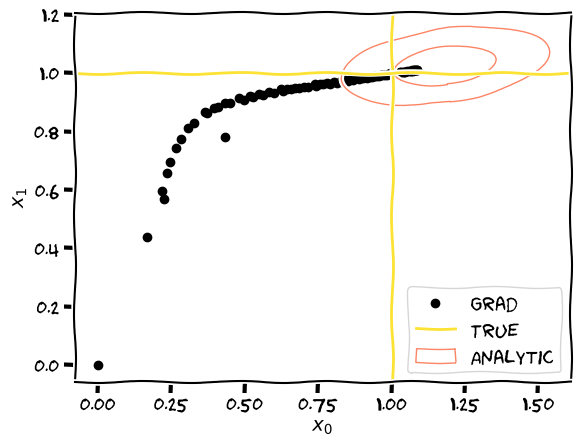

In [9]:
# Set up the observation
N = 50
true_params = torch.tensor([1, 1, 1/2]) # this is just a taylor expansion of an exponential
inputs = torch.tensor(np.random.uniform(-3,3,(1,N)).T) # these are the x values, to make all the inputs we will need some powers
inputs = inputs * torch.ones((1, 3))
for i in range(len(true_params)):
    inputs.T[i] = inputs.T[i]**i # make it a polynomial
covariance = torch.tensor(np.diag(np.random.uniform(0,4,N)))
observations = torch.sum(true_params.unsqueeze(-1) * inputs.T, dim=0) + torch.tensor(np.random.normal(loc = 0, scale = np.sqrt(np.diag(covariance))))

# Do the analytic solution for comparison
cov_inv = torch.linalg.inv(covariance).detach()
analytic_parameters, analytic_covariance = Theta_torch(inputs, observations, covariance)
print(f"Analytic optimal parameter values: {analytic_parameters.numpy()}")

# Perform gradient descent
def nll(theta):
    A = (observations - torch.sum(theta.unsqueeze(-1) * inputs.T, dim=0))
    return 0.5*A @ cov_inv @ A

def nll_grad(theta):
    theta = theta.detach()
    theta.requires_grad = True
    C2 = nll(theta)
    C2.backward()
    return theta.grad

current_params = torch.zeros(len(true_params))
trajectory = [current_params.numpy()]
lamb = 1e-3
best_chi2 = np.inf
for i in range(100):
    G = nll_grad(current_params)
    proposed_params = current_params - lamb * G
    proposed_chi2 = nll(proposed_params).item()
    if proposed_chi2 < best_chi2:
        best_chi2 = proposed_chi2
        current_params = proposed_params
        trajectory.append(current_params.numpy())
        lamb *= 1.1 # speed up grad
    else:
        lamb /= 2
trajectory = np.stack(trajectory)
print(f"Gradient Descent optimal parameter values: {trajectory[-1]}")

# Plot the results
compare_params = (0,1)
plt.scatter([trajectory[:,compare_params[0]]], [trajectory[:,compare_params[1]]], label = "Grad", color = colours[0])
plt.axvline(true_params[compare_params[0]].item(), label = "True", color = colours[1])
plt.axhline(true_params[compare_params[1]].item(), color = colours[1])
ax, ang = cov_to_ellipse(np.array([[analytic_covariance[compare_params[0],compare_params[0]].item(),analytic_covariance[compare_params[0],compare_params[1]].item(),],[analytic_covariance[compare_params[1],compare_params[0]].item(),analytic_covariance[compare_params[1],compare_params[1]].item(),]]))
for sigma in [1,2]:
    plt.gca().add_patch(Ellipse(
        xy = (analytic_parameters[compare_params[0]].item(),analytic_parameters[compare_params[1]].item()),
        width = ax[0]*2*sigma,
        height = ax[1]*2*sigma,
        angle = ang,
        fill = False,
        edgecolor = colours[2],
        label = "Analytic" if sigma == 1 else None,
    ))
plt.legend()
plt.xlabel(f"$x_{{{compare_params[0]}}}$")
plt.ylabel(f"$x_{{{compare_params[1]}}}$")
plt.gca().autoscale_view()
plt.show()

Note, however, that we don't get uncertainties on our parameters this way. We just get some parameters that are probably very close to the minimum. It can be hard to know how close they are to the minimum, or how close they are to the true parameters. Various procedures exist to figure out if the results are good, although most of them are heuristics and don't have guarantees for success.

## $\chi^2$ Optimization assuming local linearity of the forward model (Levenberg-Marquardt)

Earlier, we assumed the $\chi^2(x)$ function was locally linear. Since the $\chi^2$ is a scalar, this is simple gradient descent. However, we may also assume the the forward model is locally linear, and that the loss function is a sum of squared differences (which is the case for a Gaussian $\chi^2$). For the full story, see the excellent explanation by [Henri Gavin here](https://people.duke.edu/~hpgavin/ExperimentalSystems/lm.pdf). Imagine a function $f(\vec{x})$ which predicts an output $\vec{y}$, the Gaussian noise on $\vec{y}$ is described by a covariance matrix $C$, meaning that our $\chi^2$ is of the form:

$$\chi^2 = (\vec{y} - f(\vec{x}))^TC^{-1}(\vec{y} - f(\vec{x}))$$

If we consider a perturbation $\vec{h}$ so we now have $f(\vec{x}+\vec{h})$ we can assume $f$ is locally linear and therefore we get $f(\vec{x}+\vec{h})\approx f(\vec{x}) + J\vec{h}$, where $J$ is the Jacobian of $f$. If we insert this formula into our $\chi^2$ and optimize by setting the gradient wrt $\vec{h}$ zero and solve for the minimum $\chi^2$ we get:

$$[J^TC^{-1}J]\vec{h} = J^TC^{-1}(\vec{y} - f(\vec{x}))$$

Which is just a linear expression we can solve for $\vec{h}$. Note that $J^TC^{-1}(\vec{y} - f(\vec{x}))$ is the gradient and $J^TC^{-1}J$ is approximately the inverse Hessian.

Solving this expression will determine the minimum in a single step if the function is linear, however if it is non-linear then this can take a few steps to reach the minimum. That said, there are conditions where the above expression is unstable, so we add a damping term $\lambda$ which will allow us to smoothly transition to gradient descent if the algorithm isn't converging.

$$[J^TC^{-1}J + \lambda I]\vec{h} = J^TC^{-1}(\vec{y} - f(\vec{x}))$$

where $I$ is the identity.

A great benefit of LM is that we get an estimate of the uncertainties on the parameters for free with the result! The matrix $J^TC^{-1}J$ is approximately the inverse Hessian, so we just take $[J^TC^{-1}J]^{-1}$ and we have a covariance matrix of uncertainties for all parameters, assuming $f$ is linear enough near the minimum (which is often a good assumption).

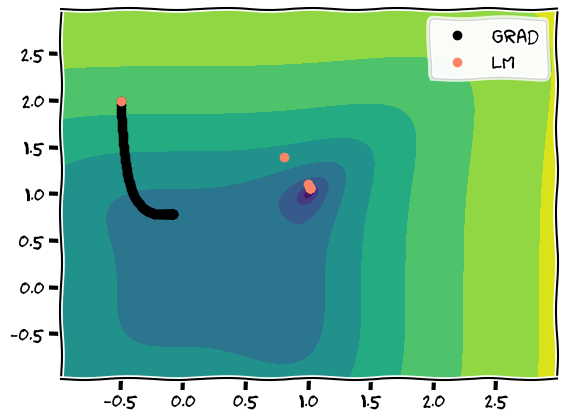

In [10]:
def LM_core(y, fx, J, C, l):
  Cinv = torch.linalg.inv(C)
  H = J.T @ Cinv @ J
  return torch.linalg.solve(H + l * torch.eye(H.shape[0]), J.T @ Cinv @ (y - fx))

def f(x):
  return (x)**3 + torch.exp(0.5*x**2 / 4) #+ torch.prod(x,dim=-1, keepdims=True)

true_x = torch.tensor([1,1])
C = torch.tensor([[0.2, 0.1],[0.1, 0.3]])
Cinv = torch.linalg.inv(C)
y = f(true_x) + torch.tensor(np.random.multivariate_normal([0,0], C.numpy()), dtype = true_x.dtype)
start_params = torch.tensor([-0.5, 2.0])

def loss(x):
  r = y - f(x)
  return 0.5 * r @ Cinv @ r.reshape(-1,1)

XX, YY = torch.meshgrid(torch.linspace(-1, 3, 100), torch.linspace(-1,3,100), indexing = "xy")
ZZ = torch.vmap(torch.vmap(loss))(torch.stack((XX, YY), dim = -1)).squeeze()
plt.contourf(torch.log(ZZ), extent = (-1, 3, -1, 3), levels = 10, origin = "lower")

# Gradient descent
def f_grad(x):
    x = x.detach().requires_grad_()
    C2 = loss(x)
    C2.backward()
    return x.grad

current_params = start_params.detach().clone()
trajectory = [current_params.numpy()]
lamb = 1e-4
best_chi2 = np.inf
for i in range(1000):
    G = f_grad(current_params)
    proposed_params = current_params - lamb * G
    proposed_chi2 = loss(proposed_params).item()
    if proposed_chi2 < best_chi2:
        best_chi2 = proposed_chi2
        current_params = proposed_params
        trajectory.append(current_params.numpy())
        lamb *= 1.1 # speed up grad
    else:
        lamb /= 1.5
trajectory = np.stack(trajectory)
plt.scatter([trajectory[:,compare_params[0]]], [trajectory[:,compare_params[1]]], label = "Grad", color = colours[0])

# Levenberg-Marquardt
current_params = start_params.detach().clone()
trajectory = [current_params.numpy()]
lamb = 1.0
best_chi2 = np.inf
jac = torch.func.jacrev(f)
for i in range(10):
  J = jac(current_params)
  fx = f(current_params)
  h = LM_core(y, fx, J, C, lamb)
  proposed_params = current_params + h
  proposed_chi2 = loss(proposed_params).item()
  if proposed_chi2 < best_chi2:
      best_chi2 = proposed_chi2
      current_params = proposed_params
      trajectory.append(current_params.numpy())
      lamb *= 9
  else:
      lamb /= 11
trajectory = np.stack(trajectory)
plt.scatter([trajectory[:,compare_params[0]]], [trajectory[:,compare_params[1]]], label = "LM", color = colours[2])
plt.legend()
plt.show()

![Pvalue.png](https://imgs.xkcd.com/comics/p_values.png)

## Gradient Based Sampling (HMC)

Gradients are nice since they give you a direction to move in the vast parameter space volume of most optimization problems. However, simple gradient descent gives you no sense of the full parameter space, just a point that has a high likelihood. We can, however, combine the speed of gradient descent with the exploration of a sampler to get a better understanding of our parameter space.

An example of this is called the Hamiltonian Monte-Carlo method. In this method we treat the likelihood (negative log likelihood) as a potential which a particle can move around in. If we start a particle with a random momentum then let it travel for some time, it will find itself in a random new place in the parameter space.

Analytic optimal parameter values: [0.70981876 0.87006787 0.59552684]


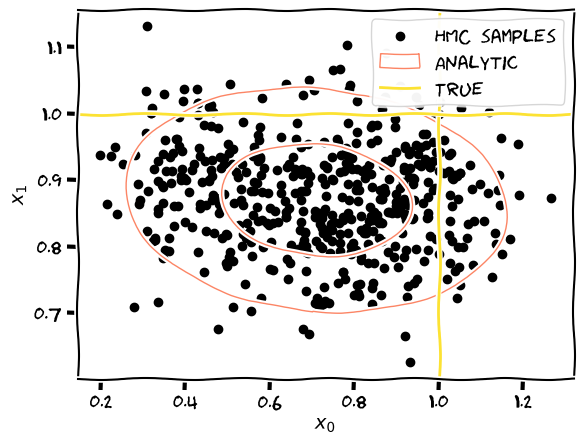

In [11]:
# Set up the observation
N = 50
true_params = torch.tensor([1, 1, 1/2]) # this is just a taylor expansion of an exponential
inputs = torch.tensor(np.random.uniform(-3,3,(1,N)).T) # these are the x values, to make all the inputs we will need some powers
inputs = inputs * torch.ones((1, 3))
for i in range(len(true_params)):
    inputs.T[i] = inputs.T[i]**i # make it a polynomial
covariance = torch.tensor(np.diag(np.random.uniform(0,4,N)))
observations = torch.sum(true_params.unsqueeze(-1) * inputs.T, dim=0) + torch.tensor(np.random.normal(loc = 0, scale = np.sqrt(np.diag(covariance))))

# Do the analytic solution for comparison
cov_inv = torch.linalg.inv(covariance).detach()
analytic_parameters, analytic_covariance = Theta_torch(inputs, observations, covariance)
print(f"Analytic optimal parameter values: {analytic_parameters.numpy()}")

# Run the HMC
def nll(theta):
    A = (observations - torch.sum(theta.unsqueeze(-1) * inputs.T, dim=0))
    return 0.5*A @ cov_inv @ A

def kinetic_energy(p, m):
    return 0.5 * p.dot(p) / m

def leapfrog(x, p, dVdx, path_len, step_size):
    n_steps = int(path_len / step_size)
    for _ in range(n_steps):
        x = x + 0.5 * step_size * p  # half step update of position
        p = p - step_size * dVdx(x)     # full step update of momentum
        x = x + 0.5 * step_size * p  # half step update of position

    return x, p

def hmc(n_samples, potential_energy, initial_position, path_len=0.1, step_size=0.01):
    x = initial_position.detach().requires_grad_()
    samples = [x.detach()]

    def dvdx(xx):
        return torch.autograd.grad(potential_energy(xx), xx)[0]
    for i in range(n_samples):
        p = torch.randn_like(x)  # initial momentum is N(0,1)
        current_H = potential_energy(x) + kinetic_energy(p, 1.0)
        x_new, p_new = leapfrog(x, p, dvdx, path_len, step_size)
        new_H = potential_energy(x_new) + kinetic_energy(p_new, 1.0)
        dH = new_H - current_H
        if torch.rand(1) < torch.exp(-dH):
            x = x_new  # accept
        samples.append(x.detach())

    return samples

# Note we only use 500 samples here instead of the 10,000 from before
samples = hmc(500, nll, true_params.detach(), path_len=0.1, step_size=0.02)
samples_np = np.array([s.numpy() for s in samples])

# Plot the results
compare_params = (0,1)
plt.scatter(samples_np[:, compare_params[0]], samples_np[:, compare_params[1]], color = colours[0], label="HMC samples")
ax, ang = cov_to_ellipse(np.array([[analytic_covariance[compare_params[0],compare_params[0]].item(),analytic_covariance[compare_params[0],compare_params[1]].item(),],[analytic_covariance[compare_params[1],compare_params[0]].item(),analytic_covariance[compare_params[1],compare_params[1]].item(),]]))
for sigma in [1,2]:
    plt.gca().add_patch(Ellipse(
        xy = (analytic_parameters[compare_params[0]].item(),analytic_parameters[compare_params[1]].item()),
        width = ax[0]*2*sigma,
        height = ax[1]*2*sigma,
        angle = ang,
        fill = False,
        edgecolor = colours[2],
        label = "Analytic" if sigma == 1 else None,
    ))
plt.axvline(true_params[compare_params[0]].item(), label = "True", color = colours[1])
plt.axhline(true_params[compare_params[1]].item(), color = colours[1])
plt.legend()
plt.xlabel(f"$x_{{{compare_params[0]}}}$")
plt.ylabel(f"$x_{{{compare_params[1]}}}$")
plt.show()

## Cross Validation or: How I Learned to Stop Worrying and Love the Variance

As another complication, we rarely know the true model for some data and so must make a guess. How can we solve this problem in a reliable way? As it turns out, that is an extremely hard question to answer, but a good starting point is cross validation. The process of cross validation is quite straightforward, we are going to fit our model to some data then we plan to use it to make predictions for future observations. So let's recreate that scenario right away. Set aside some data, fit the model to the rest, then make predictions for the aside data and see how it compares with the "truth" (observation).

Below we will test an example where the true model is a polynomial of order 3, but we don't know that. So we will try increasingly higher order polynomials until we find the best result using cross validation.

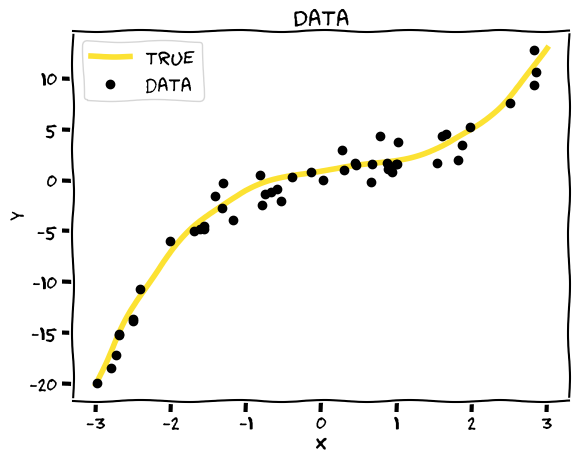

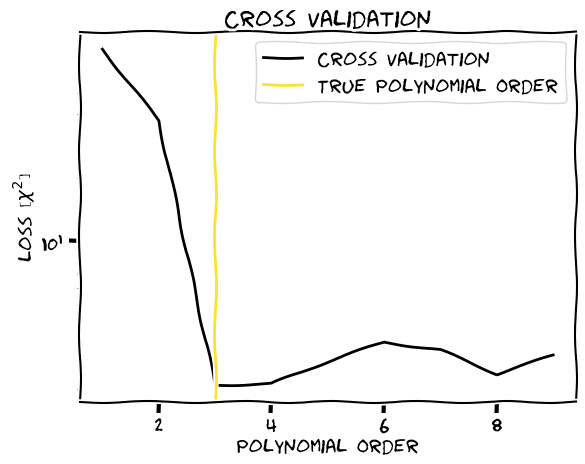

In [12]:
# Set up the observation
N = 50
true_params = np.array([1, 1, -1/2,1/2]) # this is just a taylor expansion of an exponential
inputs = np.random.uniform(-3,3,(1,N)).T # these are the x values, to make all the inputs we will need some powers
inputs = inputs * np.ones((1, 4))
for i in range(len(true_params)):
    inputs.T[i] = inputs.T[i]**i # make it a polynomial
covariance = np.diag(np.random.uniform(0,4,N))
observations = np.dot(true_params, inputs.T) + np.random.normal(loc = 0, scale = np.sqrt(np.diag(covariance)))
plt.plot(np.linspace(-3,3,100), np.polyval(list(reversed(true_params)),np.linspace(-3,3,100)), color = colours[1],linewidth=4, zorder = 0, label = "true")
plt.scatter(inputs.T[1], observations, color = colours[0], zorder = 1, label = "data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Data")
plt.show()
# Perform the cross validation
CV = KFold(n_splits = 10)
avg_losses = []
for order in range(1,10):
    inputs_order = inputs[:,1].reshape(-1,1)
    inputs_order = inputs_order * np.ones((1, order + 1))
    for i in range(order+1):
        inputs_order.T[i] = inputs_order.T[i]**i
    losses = []
    for train, test in CV.split(inputs):
        params = np.linalg.inv(inputs_order[train].T @ np.linalg.inv(covariance[train][:,train]) @ inputs_order[train]) @ inputs_order[train].T @ np.linalg.inv(covariance[train][:,train]) @ observations[train]
        pred = np.dot(params, inputs_order[test].T)
        loss = np.sum(0.5*(observations[test] - pred)**2 / np.diag(covariance)[test])
        losses.append(loss)
    avg_losses.append(np.mean(losses))
plt.plot(range(1,10), avg_losses, label = "Cross Validation", color = colours[0])
plt.yscale("log")
plt.title("Cross Validation")
plt.axvline(len(true_params)-1, label = "True Polynomial Order", color = colours[1])
plt.ylabel("loss [$\\chi^2$]")
plt.xlabel("Polynomial Order")
plt.legend()
plt.show()

## ------EXTRA------

## Linear Regression with errors on both axes

It would be nice if we could always set the parameters of our experiment and simply measure the resulting values. However, especially in astronomy, this is often not the case. Let's consider the simple scenario where we have two values with uncertainty which we expect are related by a linear relationship. The two values will be $x_0$ and $x_1$ (so together its $\vec{x}$ but now this includes the "$y$" value) and the covariance matrix of their uncertainties is $S$. The linear relationship will be presented by an angle $\theta_0$ and a displacement $\theta_1$, we use this instead of the classic m,b since the angles are more appropriate when there is no preferred axis. The angle of the linear relationship specifies an orthogonal vector to the line:

$$\vec{v} = (-\sin(\theta_0), \cos(\theta_0))$$

We can write the probability of a point $\vec{x}$ given the covariance matrix $S$ and true position $\vec{z}$ as a multivariate Gaussian:

$$p(\vec{x}|S,\vec{z}) = \frac{1}{2\pi\sqrt{{\rm det}(S)}}{\rm exp}\left(-\frac{1}{2}(\vec{x} - \vec{z})^TS^{-1}(\vec{x} - \vec{z})\right)$$

To evaluate the probability that a point $\vec{x}$ was originally on a line $\vec{\theta}$ we need to evaluate the orthogonal distance to the line, since any movement along the line has no bearing on its probability. That orthogonal distance can be written as:

$$d = \vec{v}\cdot\vec{x} - \theta_1$$

Similarly, we need to project the covariance matrix of uncertainties for the point into the orthogonal direction. This is just:

$$s^2 = \vec{v}^TS\vec{v}$$

so that the $\chi^2$ for this point can be written as:

$$\chi^2 = \frac{d^2}{s^2}$$

And of course, for many points we need only compute the sum.

Unfortunately we do not get a clean linear algebra solution for this fit, but it is a simple optimization and so very easy for standard optimizers to solve.

predicted parameter values [0.95672625 1.33244269]
predicted parameter uncertainty [0.04692104 0.17153333]


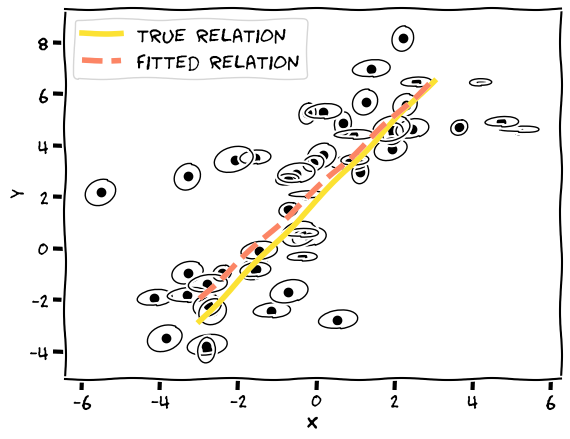

In [13]:
# Set up the observation
N = 50
true_params = np.array([1, 1]) # this is the angle, offset of the line
plt.plot(np.linspace(-3,3), np.linspace(-3,3)*np.tan(true_params[0]) + true_params[1] / np.cos(true_params[0]), label = "true relation", color = colours[1], linewidth = 4)
true_v = np.array((-np.sin(true_params[0]), np.cos(true_params[0])))
x = np.random.uniform(-3,3,(1,N))
x = x * np.ones((2, 1))
x[1] = (true_params[1] - true_v[0]*x[0]) / true_v[1]
covariance = np.random.uniform(0.1,3,(2,2,N)) # each data point has it's own covariance matrix
covariance[0,1] = np.random.uniform(0.1, 0.99) * np.array(list(min(c1,c2) for c1, c2, in zip(covariance[1,1],covariance[0,0])))
covariance[1,0] = covariance[0,1]
observations = np.array(list(np.random.multivariate_normal(mean=x[:,i], cov = covariance[:,:,i]) for i in range(N))).T

plt.scatter(observations[0], observations[1], color = colours[0])
scaling = 0.3
for i in range(N):
    ax, ang = cov_to_ellipse(covariance[:,:,i])
    plt.gca().add_patch(Ellipse(xy = observations[:,i], width = ax[0]*2*scaling, height = ax[1]*2*scaling, angle = ang, fill = False, edgecolor = "k"))

# This computes the chi^2 for a given set of parameters theta. This is what we need to minimize to find the maximum likelihood
def nll(theta):
    theta_v = np.array((-np.sin(theta[0]), np.cos(theta[0])))
    d = np.dot(theta_v, observations) + theta[1]
    s2 = np.array(list(theta_v.T @ covariance[:,:,i] @ theta_v for i in range(N)))
    return 0.5*np.sum(d**2 / s2)

res = minimize(nll, x0 = [-2,2])

predicted_parameters = res.x
predicted_covariance = res.hess_inv
predicted_parameters[0] = predicted_parameters[0] % (np.pi)
print(f"predicted parameter values {predicted_parameters}")
print(f"predicted parameter uncertainty {np.sqrt(np.diag(predicted_covariance))}")
res_v =  np.array((-np.sin(predicted_parameters[0]), np.cos(predicted_parameters[0])))
sample = np.linspace(-3,3, 5).reshape(1,5)
sample = sample*np.ones((2,1))
sample[1] = (predicted_parameters[1] - res_v[0]*sample[0]) / res_v[1]
plt.plot(sample[0], sample[1], linestyle = "--", color = colours[2], linewidth = 4, label = "fitted relation")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Linear Regression with intrinsic scatter

As if errors on both axes wasn't enough, it's also common for there to be some intrinsic scatter in the problem. Meaning that even if the measurements were perfect, there would be some scatter in the data. Consider for example galaxies, a relationship between their mass and luminosity exists, however it is not a perfect relation because the process of galaxy formation is messy. Instead we should try to fit the relation and find a value for the intrinsic scatter.

Again, we will restrict ourselves to the 2D case, though it is possible to generalize. Before, we tried to find the linear relation angle ($\theta_0$) and offset ($\theta_1$), now we will add a third parameter for the scatter orthogonal to the linear relation (surprise $\theta_3$). Our $\chi^2$ from before now becomes:

$$\chi^2 = \frac{d^2}{s^2 + \theta_3^2} + \log(s^2 + \theta_3^2)$$

As you can see, we simply add the variances in our likelihood for the data uncertainty and the intrinsic scatter. The new second term is actually not new, it comes directly from one of the first equations in the "The Math of Linear Regression" section. Except now it is not a constant we can ignore, it has to be included in the optimization.

true parameter values [ 1 -1  1]
predicted parameter values [ 1.05554267 -1.03430304 -1.02110145]
predicted parameter uncertainty [0.05875965 0.19339132 0.14345376]


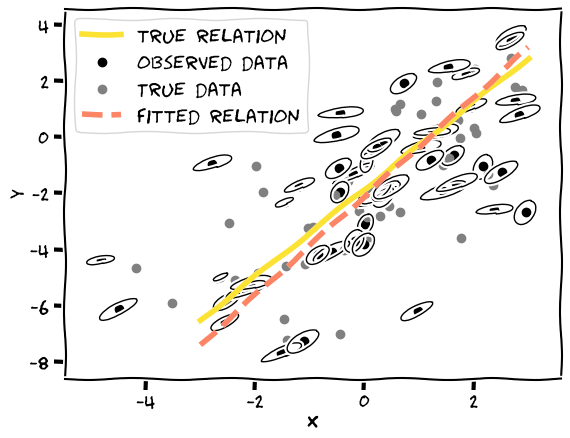

In [18]:
# Set up the observation
N = 50
true_params = np.array([1, -1, 1]) # this is the angle, offset, intrinsic scatter of the line
plt.plot(np.linspace(-3,3), np.linspace(-3,3)*np.tan(true_params[0]) + true_params[1] / np.cos(true_params[0]), label = "true relation", color = colours[1], linewidth = 4)
true_v = np.array((-np.sin(true_params[0]), np.cos(true_params[0])))
x = np.random.uniform(-3,3,(1,N))
x = x * np.ones((2, 1))
x[1] = (true_params[1] - true_v[0]*x[0]) / true_v[1]
int_scatter = np.random.normal(loc = 0., scale = true_params[2], size = N)
x[0] += -int_scatter*np.sin(true_params[0])
x[1] += int_scatter*np.cos(true_params[0])
covariance = np.random.uniform(0.1,2,(2,2,N)) # each data point has it's own covariance matrix
covariance[0,1] = np.random.uniform(0.1, 0.99) * np.array(list(min(c1,c2) for c1, c2, in zip(covariance[1,1],covariance[0,0])))
covariance[1,0] = covariance[0,1]
observations = np.array(list(np.random.multivariate_normal(mean=x[:,i], cov = covariance[:,:,i]) for i in range(N))).T
plt.scatter(observations[0], observations[1], label = "observed data", color = colours[0])
plt.scatter(x[0], x[1], label = "True data", color = "Grey")
scaling = 0.3
for i in range(N):
    ax, ang = cov_to_ellipse(covariance[:,:,i])
    plt.gca().add_patch(Ellipse(xy = observations[:,i], width = ax[0]*2*scaling, height = ax[1]*2*scaling, angle = ang, fill = False, edgecolor = "k"))

# This computes the negative log likelihood for a given set of parameters theta. This is what we need to minimize to find the maximum likelihood
def nll(theta):
    theta_v = np.array((-np.sin(theta[0]), np.cos(theta[0])))
    d = np.dot(theta_v, observations) + theta[1]
    s2 = np.array(list(theta_v.T @ covariance[:,:,i] @ theta_v for i in range(N)))
    return 0.5 * np.sum(d**2 / (s2+theta[2]**2) + np.log(s2 + theta[2]**2))

res = minimize(nll, x0 = [-2,2, 0.1])

predicted_parameters = res.x
predicted_covariance = res.hess_inv
predicted_parameters[0] = predicted_parameters[0] % (np.pi)
print(f"true parameter values {true_params}")
print(f"predicted parameter values {predicted_parameters}")
print(f"predicted parameter uncertainty {np.sqrt(np.diag(predicted_covariance))}")
res_v =  np.array((-np.sin(predicted_parameters[0]), np.cos(predicted_parameters[0])))
sample = np.linspace(-3,3, 5).reshape(1,5)
sample = sample*np.ones((2,1))
sample[1] = (predicted_parameters[1] - res_v[0]*sample[0]) / res_v[1]
plt.plot(sample[0], sample[1], linestyle = "--", label = "fitted relation", color = colours[2], linewidth = 4)
plt.legend(loc = "upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

![xkcd%20error_bars_2x.png](https://imgs.xkcd.com/comics/error_bars.png)

## Linear Regression with outliers

Ok, everything has uncertainty now, surely we are done, right? Wrong! The real world has no end of complications to add to a problem. Another very common feature of data is outliers. These are datapoints which are drawn from some distribution other than your forward model of interest. A common example in astronomical images is cosmic rays, which cause a random set of pixels to have very high values unexpectedly. Alternatively, you may be attempting to learn something about a certaint type of galaxies (say S0 galaxies) but your selection is not perfect and so you know some set of other types are getting into your data. What can you do?

There is a truly dizzying array of methods to handle outliers. Sigma clipping, regularization, manual selection, SLIC, one-class SVM, and on and on. But before diving into all of those, it should be noted that there is a formal way to handle outliers, include them in your generative model. See the original reference by Hogg et al. (https://arxiv.org/abs/1008.4686) for a Bayesian method to handle this scenario.